In [76]:
import numpy as np
import pandas as pd
import spacy
import networkx as nx
import score as sc
import time
from sklearn.metrics import confusion_matrix, pairwise
from scipy.spatial import distance
from preprocessing.utils import plot_confusion_matrix
import matplotlib.pyplot as plt
import nltk
from collections import Counter, defaultdict
#https://github.com/huggingface/neuralcoref
#note: this NEEDS spacy 2.0.12 to work! downgrade with pip install spacy=2.0.12
import en_coref_md
nlp = spacy.load('en_core_web_sm')
coref = en_coref_md.load()

In [303]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()
def get_sentiment(sentence):
    sent =  vader.polarity_scores(sentence.text)
    return [sent["pos"],sent["neg"],sent["neu"],sent["compound"]]

def get_avg_sentiment(lst):
    sents = np.array([get_sentiment(s) for s in lst])
    return list(np.mean(sents, axis = 0))

def get_diff_sentiment(a,b):
    return list(np.absolute(np.array(a) - np.array(b)))

In [41]:
def train_test_split(bodies, stances, split=0.8):
    idx = np.random.permutation(np.arange(len(bodies)))
    bodies = bodies.values[idx]
    train = int(len(bodies)*0.8)
    bodies_tr = set([i[0] for i in bodies[:train]])
    bodies_val = set([i[0] for i in bodies[train:]])
    stances_tr = stances.loc[stances["Body ID"].isin(bodies_tr), :]
    stances_val = stances.loc[stances["Body ID"].isin(bodies_val), :]
    return stances_tr, stances_val

In [42]:
train_stances = pd.read_csv("fn_data/train_stances.csv")
train_stances = train_stances.loc[lambda x: x.Stance != "unrelated"]
print(train_stances.shape)
train_stances.head(15)

(13427, 3)


,Headline,Body ID,Stance
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
4,Spider burrowed through tourist's stomach and ...,1923,disagree
5,'Nasa Confirms Earth Will Experience 6 Days of...,154,agree
8,Banksy 'Arrested & Real Identity Revealed' Is ...,1739,agree
10,Gateway Pundit,2327,discuss
11,Woman detained in Lebanon is not al-Baghdadi's...,1468,agree
14,"Soon Marijuana May Lead to Ticket, Not Arrest,...",47,discuss
16,Boko Haram Denies Nigeria Cease-Fire Claim,2463,discuss
17,"No, Robert Plant Didn’t Rip Up an $800 Million...",295,agree
19,ISIL Beheads American Photojournalist in Iraq,608,discuss


In [43]:
train_bodies = pd.read_csv("fn_data/train_bodies.csv")
print(train_bodies.shape)
train_bodies.head()

(1683, 2)


,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [44]:
stances_tr, stances_val = train_test_split(train_bodies, train_stances)
stances_tr.shape, stances_val.shape

((10795, 3), (2632, 3))

In [222]:
disagrees = stances_tr[stances_tr["Stance"]=="disagree"]
agrees = stances_tr[stances_tr["Stance"]=="agree"]
discusses = stances_tr[stances_tr["Stance"]=="discuss"]
stances_tr_augmented = pd.concat([stances_tr, agrees, disagrees, disagrees, disagrees, disagrees, disagrees, disagrees, disagrees]).sample(frac=1).reset_index(drop=True)

In [46]:
def get_body(n):
    return train_bodies.loc[lambda x: x["Body ID"] == n, "articleBody"].item()

In [47]:
def preprocess(text):
    text = text.replace("' ",' ')
    text = text.replace(" '",' ')
    text = text.replace(":", ". ")
    text = text.replace(";", ". ")
    return text

In [48]:
def cosine_similarity(x,y):
    return 1 - distance.cosine(x,y)

In [49]:
neg_words = set(["n't", "not", "no", "never", "nobody", "non"])
doubt_words = set(['fake','fraud', 'hoax', 'false', 'deny', 'denies', 'despite', 'nope', 'doubt', 'bogus', 'debunk', 'prank', 'retract', 'scam', "withdrawn","misinformation"])
nr_words = neg_words.union(doubt_words)

In [50]:
def get_topics(doc):
    """
    get topics of a sentence
    input: spacy doc
    output: dictionary with nouns as the key, and the set of noun chunks that contain the noun as the value
    """
    subjs = {}
    for token in doc:
        if token.dep_ in ["nsubj", "nsubjpass", "csubj","csubjpass", "dobj", "dative", "attr", "oprd", "pobj", "compound"]:
            txt = token.lemma_.lower()
            if txt not in subjs:
                subjs[txt] = set([txt])      
    for chunk in doc.noun_chunks:
        if len(chunk.root.text) > 2:
            txt = chunk.root.text.lower()
            if txt not in subjs:
                subjs[txt] = set([txt])
            subjs[txt].add(chunk.text.lower())
    subjects_= []
    for word in subjs:
        for phrase in subjs[word]:
            subjects_ += phrase.split(" ")
    subjs["_vocab"] = set(subjects_)
    return subjs

In [51]:
def get_svos(sent):
    """
    input: Spacy processed sentence
    output: 3x2 tuple, each entry contains the word, and whether that word it's children are negating words
    ex: "he did not hit the ball" -> (("-pron-", False),("hit", True), ("ball", False))
    """
    def check_neg(tok):
        neg_children = len([c.lemma_.lower() for c in tok.children if c.lemma_.lower() in neg_words])
        if neg_children > 0 or (tok.lemma_.lower() in neg_words):
            return -1
        return 1
    s = []
    v = []
    o = []
    for token in sent:
        if token.dep_ == 'ROOT':
            v.append((token.lemma_.lower(), check_neg(token)))
        elif token.dep_ in ["nsubj", "nsubjpass", "csubj","csubjpass", "agent","compound"]:
            s.append((token.lemma_.lower(), check_neg(token)))
        elif token.dep_ in ["dobj", "dative", "attr", "oprd", "pobj"]:
            o.append((token.lemma_.lower(), check_neg(token)))
    # https://github.com/clir/clearnlp-guidelines/blob/master/md/specifications/dependency_labels.md
    return (s,v,o)

In [52]:
def build_graph(doc):
    """
    build a NetworkX graph of the dependency tree
    input: spacy Doc
    output: networkx graph
    """
    edges = set()
    for token in doc:
        if len(token) > 1:
            for child in token.children:
                if len(child) > 1:
                    edges.add((token.lemma_.lower(),child.lemma_.lower()))
    graph = nx.Graph(list(edges))
    return graph

In [152]:
def get_summary(doc, subjects, n = 5):
    """
    get summary of n sentences in document
    custom sentence scoring metric, first sentence will always be returned
    """
    subjects_ = subjects["_vocab"]
    def score_sentence(doc):
        # not very robust right now
        score = 0
        word_count = 0
        for token in doc:
            word_count += 1
            t = token.lemma_.lower()
            if t in subjects_:
                score += 1
            elif t in nr_words:
                score += 1
        return score/word_count
    sentences = [s for s in doc.sents]
    scored_sentences = [[idx, sent, score_sentence(sent)] for idx, sent in enumerate(sentences)]
    include_first = False
    if scored_sentences[0][-1] != 0:
        include_first = True
    scored_sentences.sort(key = lambda x: x[2], reverse = True)
    if include_first:
        top = scored_sentences[:n-1]
        top.sort(key = lambda x: x[0])
        result = [sentences[0]] + [s[1] for s in top]
    else:
        top = scored_sentences[:n]
        top.sort(key = lambda x: x[0])
        result = [s[1] for s in top]
    return result

In [118]:
def get_shortest_path_to_negating(graph, subjects):
    """
    get the shortest path from each subject to any negating word
    returns: dictionary with subject as key, and 2-element list of path length and the actual path as the value
    - if a subject does not exist in graph, then result will not include that subject as key
    - if a subject does not have a path to any negating word, then the value will be [None, None]
    """
    results = {}
    for s in subjects:
        if graph.has_node(s) and s not in nr_words:
            results[s] = [None, None] #length of path, path
            for word in nr_words:
                if word in graph:
                    try:
                        path = nx.shortest_path(graph, source = s, target = word)
                        if results[s][0] == None or len(path) < results[s][0]:
                            results[s][0] = len(path)
                            results[s][1] = path
                    except:
                        continue
    return results

In [119]:
# https://github.com/CornellDataScience/Summarization/blob/master/textrank2.py
import editdistance
import itertools
import networkx as nx
import nltk


def build_tr_graph(nodes):
    """
    Return networkx graph instance built from nodes
    """
    #initialize graph
    graph = nx.Graph()  
    graph.add_nodes_from(nodes)
    nodePairs = list(itertools.combinations(nodes, 2))

    #add edges weighted by Levenshtein distance
    for pair in nodePairs:
        levDistance = editdistance.eval(pair[0], pair[1])
        graph.add_edge(pair[0], pair[1], weight=levDistance)

    return graph


def extract_sentences(text, clean_sentences=False, language='english'):
    """
    Return list of sentences in text sorted in descending order of importance
    """
    sent_detector = nltk.data.load('tokenizers/punkt/'+language+'.pickle')
    sentence_tokens = sent_detector.tokenize(text.strip())
    graph = build_tr_graph(sentence_tokens)

    calculated_page_rank = nx.pagerank(graph, weight='weight')

    #list of most important sentences first
    sentences = sorted(calculated_page_rank, key=calculated_page_rank.get,
                       reverse=True)

    return sentences

def get_summary_tr(text, numSentences=1):
    '''
    Return summary of text in numSentences sentences (default: 1)
    '''
    sentences = extract_sentences(text)

    if numSentences > len(sentences) or numSentences == 1: summary = sentences[0]
    
    else: 
        summary = ' '.join(sentences[:numSentences])
        summary_words = summary.split()
        dot_indices = [idx for idx, word in enumerate(summary_words) if word.find('.') != -1]
        if dot_indices:
            last_dot = max(dot_indices) + 1
            summary = ' '.join(summary_words[:last_dot])
        else:
            summary = ' '.join(summary_words)
    return summary

In [120]:
story_words = ["story","news","article","report","reportedly"]

In [121]:
def get_story_words_neg(doc):
    relevant_words = []
    for token in doc:
        if token.lemma_.lower() in story_words:
            relevant_words += [c.lemma_.lower() for c in token.children]
            relevant_words += [a.lemma_.lower() for a in token.ancestors]
    return len(set(relevant_words).intersection(nr_words)) != 0

In [122]:
def get_neg_ancestors(doc):
    """
    get the ancestors of every negating word
    input: spacy Doc
    returns: (number of negating words, number of refuting words, set of words that were in the ancestor list of negating words)
    """
    results = [0,0,[]]
    for s in doc.sents:
        for token in s:
            if token.lemma_.lower() in neg_words:
                results[0] += 1
                results[2] += [ancestor.lemma_.lower() for ancestor in token.ancestors if len(ancestor) > 2]
            elif token.lemma_.lower() in doubt_words:
                results[1] += 1
                results[2] += [ancestor.lemma_.lower() for ancestor in token.ancestors if len(ancestor) > 2]
    results[2] = set(results[2])
    return results

In [330]:
h_id = 0
df = disagrees
test = nlp(preprocess(list(df.values)[h_id][0]))
print(test)
test_graph = build_graph(test)
test_subj = get_topics(test)
#print(test_subj)
test_svo = get_svos(test)
print(get_shortest_path_to_negating(test_graph, test_subj))
print(test_svo)

Pope Francis turns out not to have made pets in heaven comment
{'pope': [5, ['pope', 'francis', 'turn', 'make', 'not']], 'francis': [4, ['francis', 'turn', 'make', 'not']], 'pet': [4, ['pet', 'comment', 'make', 'not']], 'heaven': [6, ['heaven', 'in', 'pet', 'comment', 'make', 'not']]}
([('pope', 1), ('francis', 1), ('pet', 1)], [('turn', 1)], [('heaven', 1)])


In [331]:
body_text = get_body(list(df.values)[h_id][1])
# print(body_text)
# print("")
body = coref(preprocess(body_text))
resolved = body._.coref_resolved
# print(resolved)
# print("")
body = nlp(resolved)
summary = get_summary(body, test_subj, 5)
print(summary)
svos = [get_svos(s) for s in summary]
for s in svos:
    print(s)

[NEW YORK — Pope Francis has given hope to gays, unmarried couples and advocates of the Big Bang theory., Now, Pope Francis has endeared Pope Francis to dog lovers, animal-rights activists and vegans.

, Trying to console a little boy whose dog had died, Pope Francis told Pope Francis in a recent public appearance on St Peter’s Square that “paradise is open to all of God’s creatures”., Theologians cautioned that Pope Francis had spoken casually, not made a doctrinal statement.

, Pope Francis said paradise is open to all creatures,” Rev Martin said.

]
([('pope', 1), ('francis', 1), ('big', 1), ('bang', 1)], [('give', 1)], [('hope', 1), ('theory', 1)])
([('pope', 1), ('francis', 1), ('pope', 1), ('dog', 1), ('animal', 1), ('right', 1)], [('endear', 1)], [('francis', 1), ('lover', 1)])
([('dog', 1), ('pope', 1), ('francis', 1), ('pope', 1), ('st', 1), ('"', 1), ('paradise', 1)], [('tell', 1)], [('boy', 1), ('francis', 1), ('appearance', 1), ('square', 1), ('all', 1), ('creature', 1)])
(

In [332]:
print(get_neg_ancestors(test))
print(get_neg_ancestors(body))

[1, 0, {'turn', 'make'}]
[3, 0, {'speak', 'believe', 'say', 'caution', 'make', 'mean'}]


In [113]:
svo_list = test_svo[0] + test_svo[1] + test_svo[2]
svo_set = defaultdict(int)
for s in svos:
    for item in s:
        for pair in item:
            svo_set[pair[0]] = pair[1]
headline_vec = [x[1] for x in svo_list]
body_vec = [svo_set[x[0]] for x in svo_list]
print(headline_vec, body_vec)
cosine_similarity(headline_vec, body_vec)

[1, 1, 1, 1, 1] [1, 1, 0, 0, 0]


0.6324555320336759

In [114]:
headline_info = {}
body_info = {}
start = time.time()
stance_data = list(train_stances.values)
body_data = list(train_bodies.values)
for headline in range(len(stance_data)):
    if headline % 2500 == 0:
        print("Processed "+str(headline))
    h, b_id, s = tuple(stance_data[headline])
    h_ = preprocess(h)
    nlp_h = nlp(h_)
    headline_graph = build_graph(nlp_h)
    headline_subj = get_topics(nlp_h)
    headline_svo = get_svos(nlp_h)
    headline_info[h] = (nlp_h, headline_graph, headline_subj, headline_svo)
print("Done!")
for body in range(len(body_data)):
    if body % 100 == 0:
        print("Processed "+str(body))
    b_id, txt = tuple(body_data[body])
    nlp_a = coref(preprocess(txt))
    nlp_b = nlp(nlp_a._.coref_resolved)
    body_graph = build_graph(nlp_b)
    body_info[b_id] = (nlp_b, body_graph)
print("Done!")
end = time.time()
print(int(end-start))

Processed 0
Processed 2500
Processed 5000
Processed 7500
Processed 10000
Processed 12500
Done!
Processed 0
Processed 100
Processed 200
Processed 300
Processed 400
Processed 500
Processed 600
Processed 700
Processed 800
Processed 900
Processed 1000
Processed 1100
Processed 1200
Processed 1300
Processed 1400
Processed 1500
Processed 1600
Done!
843


In [311]:
def get_features(stance_df, n_sent = 5):
    start = time.time()
    data = list(stance_df.values)
    features = []
    actual = []
    for item in data:
        h, b, s = tuple(item)
        nlp_h, headline_graph, headline_subjs, headline_svo = headline_info[h]
        nlp_b, body_graph = body_info[b]
        
        #sometimes the coref deletes bodies that are one sentence
        if len(nlp_b) == 0:
            nlp_b = nlp(preprocess(get_body(b)))
            body_graph = build_graph(nlp_b)

        #return the shortest path to negating word for each subject in headline_subjs, if one exists
        neg_h = get_shortest_path_to_negating(headline_graph, headline_subjs)
        neg_b = get_shortest_path_to_negating(body_graph, headline_subjs)

        shared_subjects = set(neg_h).intersection(set(neg_b)) 
        # subjects talked about negatively by both headline and body
        p_one = 0
        p_neither = 0
        p_both = 0
        for sub in shared_subjects:
            nh, nb = neg_h[sub],  neg_b[sub]
            #one doc mentions negatively, the other does not
            if nh[0] == None and nb[0] != None and nb[0] <= 5:
                p_one += 1
            elif nh[0] != None and nb[0] == None and nh[0] <= 5:
                p_one += 1
            #both docs mention negatively
            elif nh[0] != None and nb[0] != None:
                p_both += 1
            else:
                p_neither += 1
        if len(shared_subjects) == 0:
            shared_subjects.add("_")
        shared_subjs_cos_sim = (p_neither + p_both - p_one)/(len(shared_subjects) * len(shared_subjects))
        p_one /= len(shared_subjects)
        p_neither /= len(shared_subjects)
        p_both /= len(shared_subjects)

        if len(headline_subjs["_vocab"]) == 0:
            headline_subjs["_vocab"].add("_")
        neg_subj = headline_subjs["_vocab"].intersection(nr_words)
        p_neg_subj = len(neg_subj)/len(headline_subjs["_vocab"])

        #embedding vector based on subject, verb, object
        #for each svo in headline, headline vector entry is 1 if not negated, -1 if negated
        #if not present in body, then entry is 0, otherwise 1 if not negated, -1 if negated
        svo_list = headline_svo[0] + headline_svo[1] + headline_svo[2]
        summary = get_summary(nlp_b, headline_subjs, n_sent)
        body_svo = [get_svos(s) for s in summary]
        svo_set = defaultdict(int)
        for svo in body_svo:
            for item in svo:
                for pair in item:
                    svo_set[pair[0]] = pair[1]
        headline_vec = [x[1] for x in svo_list]
        body_vec = [svo_set[x[0]] for x in svo_list]
        #cosine similarity of stance vecs
        svo_cos_sim = 0
        if len(svo_list) != 0 and sum(headline_vec) != 0 and sum(body_vec) != 0:
            svo_cos_sim = cosine_similarity(headline_vec, body_vec)
            
        
        #are any words that refer to an article/story negated in the body
        body_neg_story = int(any([get_story_words_neg(s) for s in summary]))
        
        #number of refuting/negating words in head and body, ancestors of those words
        n_neg_head, n_ref_head, neg_ancestors_head = get_neg_ancestors(nlp_h)
        n_neg_body, n_ref_body, neg_ancestors_body = get_neg_ancestors(nlp_b)
        n_punct_body = 0 #irregular punctuation
        for tok in nlp_b:
            if tok.text in ["?","!"]:
                n_punct_body +=1

        body_head_neg = 0 # number of ancestors in body that are also ancestors in head
        head_body_neg = 0 # number of ancestors in head that are also ancestors in body
        body_subj_neg = 0 # number of ancestors in body that are topics in head
        head_subj_neg = 0 # number of ancestors in body that are topics in body summary
        
        for word in neg_ancestors_body:
            if word in neg_ancestors_head:
                body_head_neg += 1
            elif word in headline_subjs["_vocab"]:
                body_subj_neg += 1
        
        for word in neg_ancestors_head:
            if word in neg_ancestors_body:
                head_body_neg += 1
            elif word in svo_set:
                head_subj_neg += 1
        
        #sentiment
        avg_hd_sent = get_avg_sentiment(nlp_h.sents)
        avg_body_sent = get_avg_sentiment(summary)
        diff_avg_sent = get_diff_sentiment(avg_hd_sent, avg_body_sent)
        body_sents = [get_sentiment(s) for s in summary]
        cos_sim_sents = np.mean([np.nan_to_num(cosine_similarity(s, avg_hd_sent)) for s in body_sents])
            
        features.append([
            p_one, 
            p_neither, 
            p_both, 
            shared_subjs_cos_sim,
            p_neg_subj, 
            svo_cos_sim, 
            body_neg_story, 
            n_ref_head, 
            n_neg_head, 
            n_ref_body, 
            n_neg_body,
            n_punct_body,
            body_head_neg,
            body_subj_neg,
            head_body_neg,
            head_subj_neg,
            cos_sim_sents,
        ] + diff_avg_sent)
        actual.append(s)
    end = time.time()
    print(int(end-start))
    return features, actual

In [321]:
training_data = get_features(stances_tr, 5)
testing_data = get_features(stances_val, 5)

/Users/dannyyang/Library/Python/3.6/lib/python/site-packages/scipy/spatial/distance.py:505: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))


90
24


In [322]:
for i in range(len(training_data[0][0])):
    r = []
    for row in training_data[0]:
        r.append(row[i])
    print(r[:25])

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.75, 0.0, 0.6]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.25, 1.0, 0.4]
[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[-0.2, 0.0, 0.2, 0.2, 0.2, 0.25, 1.0, -0.16666666666666666, 0.5, 0.2, 0.25, 0.3333333333333333, -0.14285714285714285, 0.2, 0.3333333333333333, 0.3333333333333333, 0.16666666666666666, 0.0, -1.0, -0.125, -0.16666666666666666, -0.2, -0.125, 0.5, -0.04]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.7559289460184544, 0, 1.0000000000000002, 0.8164965809277261, 0.7559289460184544, 0.7745966692414834, 0, 0.7071067811865475, 0.6546536707079772, 0.5070925528371099, 0.7559289460184544, 0.7745966692414834, 0.8366600265340756, 0.91287092917527

In [323]:
print(Counter(training_data[1]), Counter(testing_data[1]))

Counter({'discuss': 7146, 'agree': 2990, 'disagree': 659}) Counter({'discuss': 1763, 'agree': 688, 'disagree': 181})


In [324]:
1763 /(1763 + 688 + 181)

0.6698328267477204

In [325]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
# model = DecisionTreeClassifier()
# model = RandomForestClassifier(n_estimators = 100)
model = LogisticRegression(max_iter = 200)
# model = SVC()
model.fit(training_data[0], training_data[1])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [326]:
tr_acc = model.score(training_data[0], training_data[1])
print('{0:.2f}% training accuracy'.format(tr_acc*100))
val_acc = model.score(testing_data[0], testing_data[1])
print('{0:.2f}% validation accuracy'.format(val_acc*100))

68.50% training accuracy
68.54% validation accuracy


In [327]:
print(model.classes_, model.coef_)

['agree' 'disagree' 'discuss'] [[-1.01948879 -0.62400861 -0.74736462  0.14289115  2.79513969  0.6283766
   0.34581344  0.47305097  0.74784198  0.04682519 -0.01213821  0.06954832
   0.17266047 -0.17803413  0.17266047 -0.16636371 -1.47433563  0.39117567
  -0.02985435  0.15373507 -0.35922682]
 [ 0.67824127 -0.43644438 -0.05316765  0.13132758 -0.07954039 -1.45056218
   0.10790295  0.26456214  0.18529606  0.12865576  0.0088836   0.093455
  -0.22274265  0.06884118 -0.22274265  0.17338158  0.65301937  0.73660018
  -1.1302591  -0.13605949  0.0141109 ]
 [ 0.65988462  0.44568602  0.64148373 -0.10878163 -2.7902204  -0.09956303
  -0.35150212 -0.57521184 -0.83486035 -0.11245675  0.00528066 -0.10826955
  -0.12822394  0.11615287 -0.12822394  0.11566371  0.90926911 -0.68412939
   0.29071718 -0.16332454  0.20477092]]


In [328]:
actual = testing_data[1]
predicted = model.predict(testing_data[0])

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    114    |     0     |    574    |     0     |
-------------------------------------------------------------
| disagree  |    14     |     0     |    167    |     0     |
-------------------------------------------------------------
|  discuss  |    72     |     1     |   1690    |     0     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     0     |     0     |
-------------------------------------------------------------
Score: 2011.0 out of 2632.0	(76.40577507598785%)
Normalized confusion matrix
[[1.65697674e-01 0.00000000e+00 8.34302326e-01]
 [7.73480663e-02 0.00000000e+00 9.22651934e-01]
 [4.08394782e-02 5.67214974e-04 9.58593307e-01]]


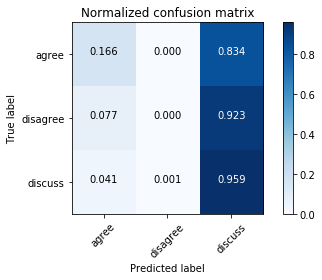

In [329]:
sc.report_score(actual, predicted)
matrix = confusion_matrix(actual,predicted)
plot_confusion_matrix(matrix, classes=["agree","disagree", "discuss"],
                      title='Normalized confusion matrix')
plt.show()